# Notes for geoinformatics
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
import geopandas as gpd
import geodatasets

from pyproj import Geod

In [2]:
# Loading world data for the basemap
world_path = geodatasets.get_path("naturalearth.land")
world = gpd.read_file(world_path)

# Points and Lines
---

LINESTRING (4.8357 45.764, 100 50)
POLYGON ((2.3522 48.8566, 13.405 52.52, 4.8357 45.764, 2.3522 48.8566))


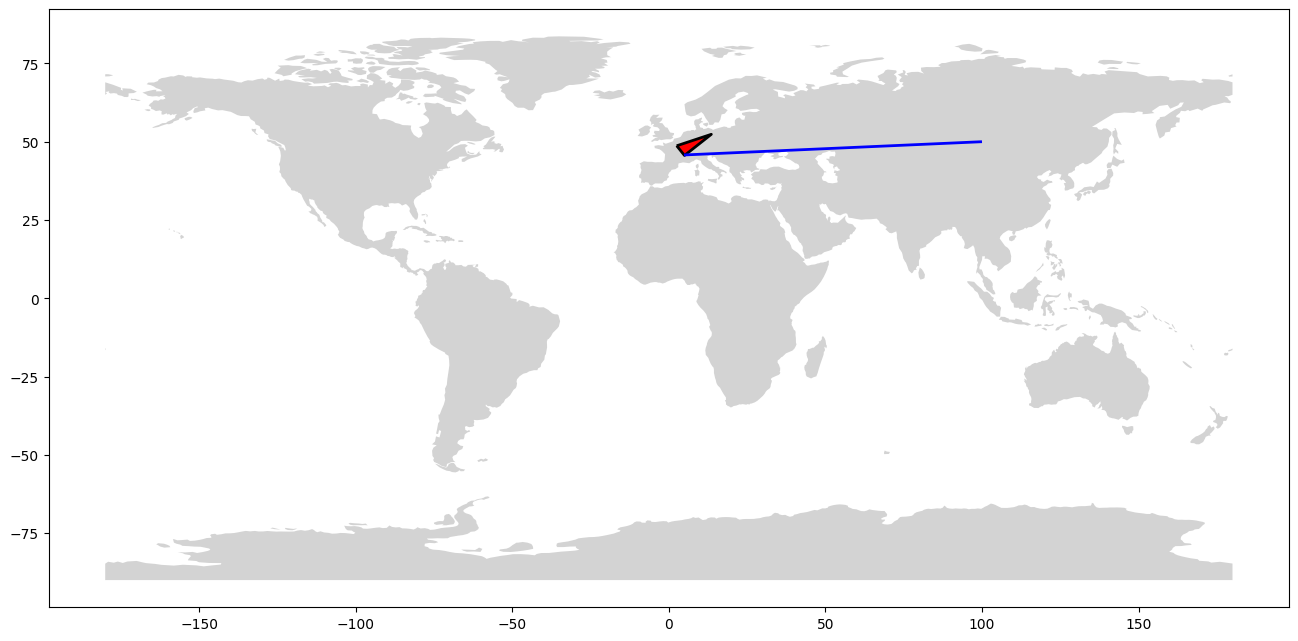

In [3]:
paris = Point(2.3522, 48.8566)
berlin = Point(13.4050, 52.5200)
other = Point(4.8357, 45.7640)
another = Point(100.0, 50.0)

line = LineString([other, another])
print(line)

triangle = Polygon( [ paris, berlin, other ] )
print(triangle)

gdf = gpd.GeoDataFrame(geometry=[line, triangle])

fig, ax = plt.subplots(figsize=(16, 9))
world.plot(ax=ax, color="lightgrey")
gdf.plot(ax=ax, color=["blue", "red"], linewidth=2, edgecolor="black")

plt.show()

# Curved Lines
---

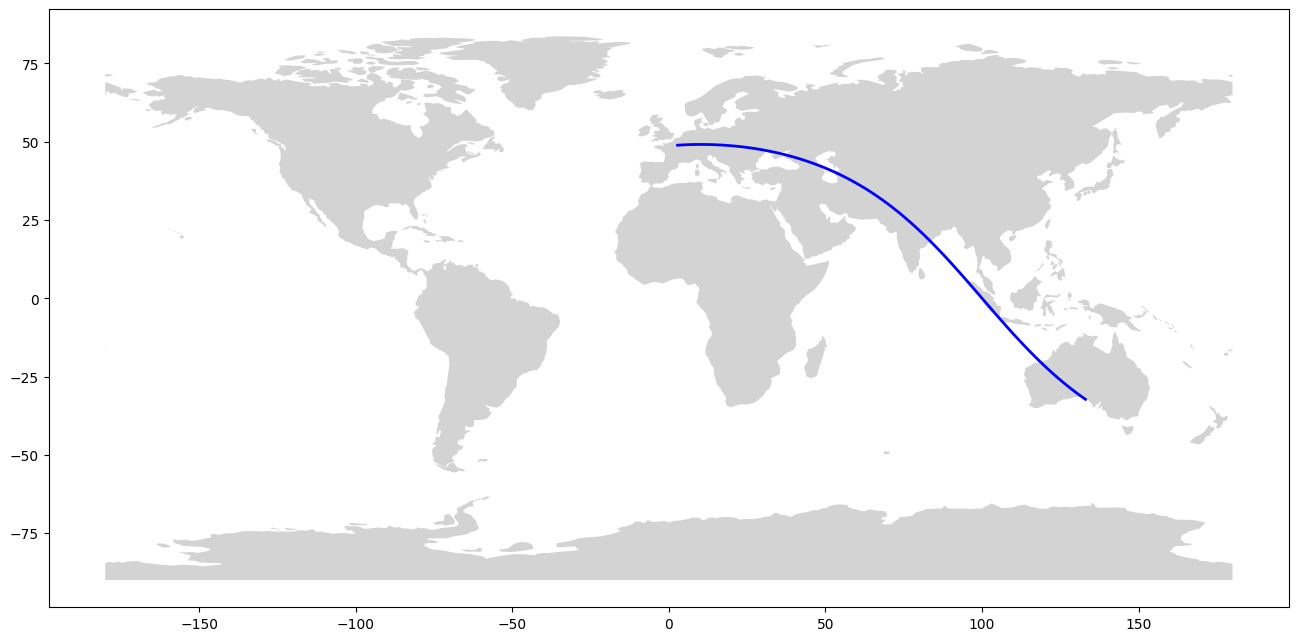

In [4]:
geod = Geod(ellps="WGS84") # Create ellipsoid

num_points = 100 # Adjust for smoothness

paris = (2.3522, 48.8566)
berlin = (133.4050, -32.5200)

points = geod.npts(paris[0], paris[1], berlin[0], berlin[1], num_points)

points.insert(0, paris)
points.append(berlin)

curved_line = LineString(points)

gdf = gpd.GeoDataFrame(geometry=[curved_line])

fig, ax = plt.subplots(figsize=(16, 9))
world.plot(ax=ax, color="lightgrey")
gdf.plot(ax=ax, color=["blue"], linewidth=2)

plt.show()

# Polygons
---

In [5]:
bogota = (144.9631, -37.8142)
melbourne = (-74.0722, 4.7111)
paris = (2.3522, 48.8567)
tokyo = (139.6922, 35.6897)

cities = [bogota, melbourne, paris, tokyo]

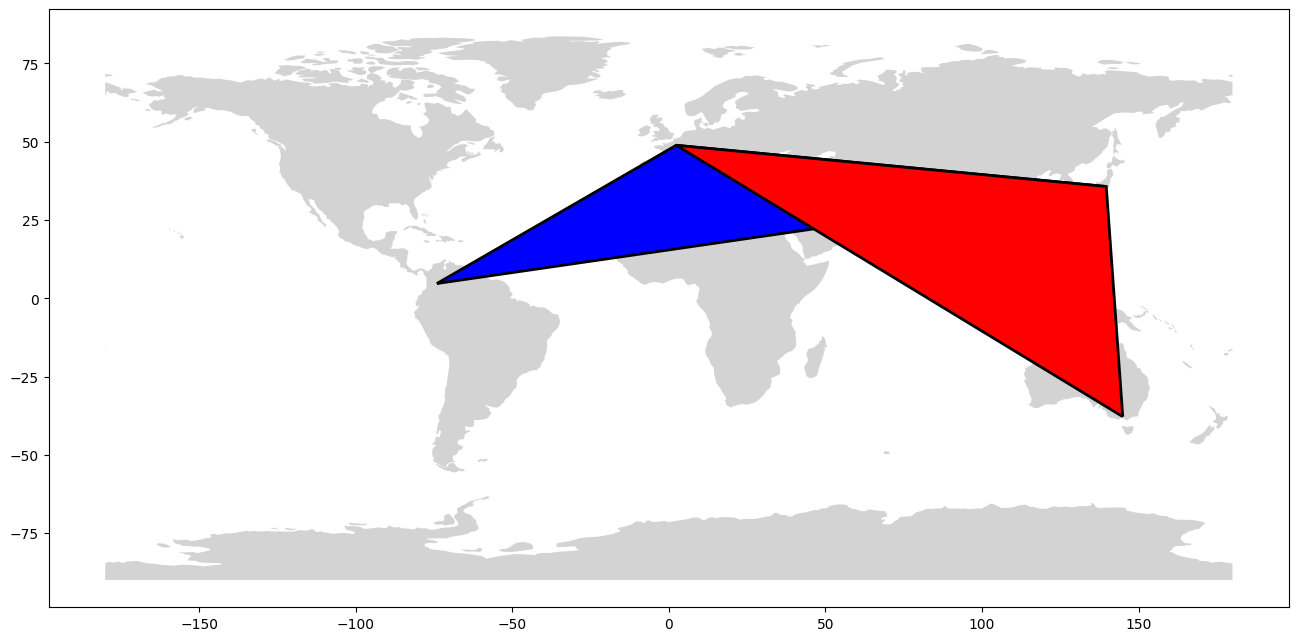

In [6]:
points_a = [Point(*city) for city in cities if city != bogota]
points_b = [Point(*city) for city in cities if city != melbourne]

territory_a = Polygon(points_a)
territory_b = Polygon(points_b)

gdf = gpd.GeoDataFrame(geometry=[territory_a, territory_b])

fig, ax = plt.subplots(figsize=(16, 9))
world.plot(ax=ax, color="lightgrey")
gdf.plot(ax=ax, color=["blue", "red"], linewidth=2, edgecolor="black")

plt.show()

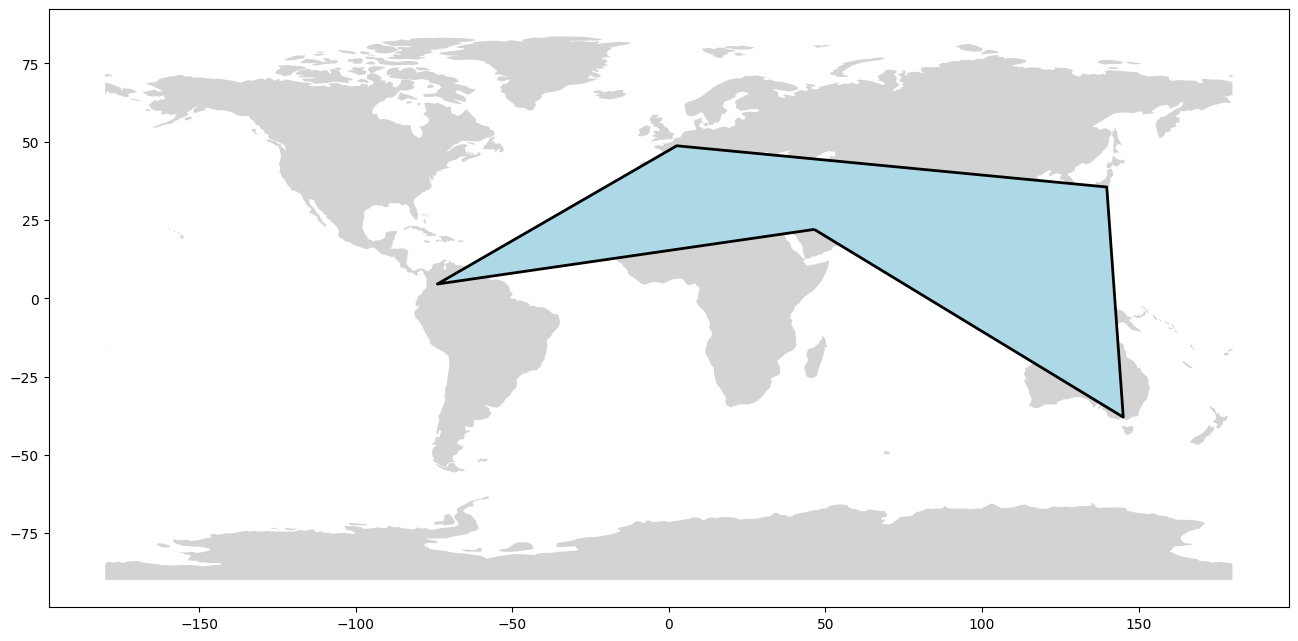

In [7]:
merged_territory = gdf.geometry.union_all()

merged_gdf = gpd.GeoDataFrame(geometry=[merged_territory])

fig, ax = plt.subplots(figsize=(16, 9))
world.plot(ax=ax, color="lightgrey")
merged_gdf.plot(ax=ax, color="lightblue", linewidth=2, edgecolor="black")

plt.show()

# Wind in Hemispheres
---

**North**
- **High**: Anticylonic divergent (*clockwise*)
- **Low** : Cylonic convergent (*counterclockwise*)

**South**
- **High**: Anticyclonic divergent (*counterclockwise*)
- **Low** : Cyclonic convergent (*clockwise*)

In [8]:
spirals_path = geodatasets.get_path("geoda.spirals")
spirals_df = pd.read_csv(spirals_path).astype({"x": float, "y": float})

In [9]:
spiral_nh_points = [Point(25 * x + 60, (y * 25) + 30) for x, y in zip(spirals_df["x"], spirals_df["y"])]

spiral_nl_points = [Point(25 * x - 60, (-y * 25) + 30) for x, y in zip(spirals_df["x"], spirals_df["y"])]

spiral_sh_points = [Point(25 * x - 60, (-y * 25) - 30) for x, y in zip(spirals_df["x"], spirals_df["y"])]

spiral_sl_points = [Point(25 * x + 60, (y * 25) - 30) for x, y in zip(spirals_df["x"], spirals_df["y"])]

In [10]:
spiral_nh_gdf = gpd.GeoDataFrame(geometry=spiral_nh_points)

spiral_nl_gdf = gpd.GeoDataFrame(geometry=spiral_nl_points)

spiral_sh_gdf = gpd.GeoDataFrame(geometry=spiral_sh_points)

spiral_sl_gdf = gpd.GeoDataFrame(geometry=spiral_sl_points)

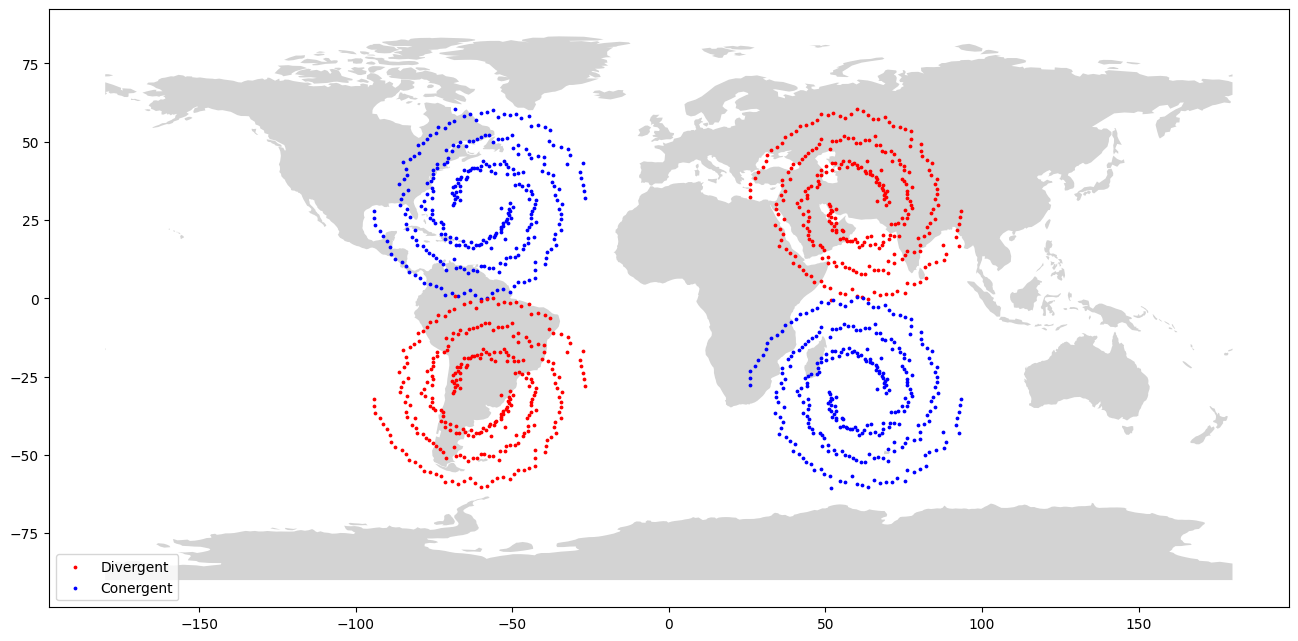

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
world.plot(ax=ax, color="lightgrey")

spiral_nh_gdf.plot(ax=ax, marker="o", markersize=3, color="red", label="Divergent") # clock
spiral_nl_gdf.plot(ax=ax, marker="o", markersize=3, color="blue", label="Conergent") # counterclock

spiral_sh_gdf.plot(ax=ax, marker="o", markersize=3, color="red") # counterclock
spiral_sl_gdf.plot(ax=ax, marker="o", markersize=3, color="blue") # clock

plt.legend(loc="lower left")
plt.show()

In [12]:
R = 6_371_000 # Eearths radius in meters

def cartesian_to_geo(x, y, lon0, lat0, z=0, h0=0):
    # Reference point
    lon0_rad = np.radians(lon0)
    lat0_rad = np.radians(lat0)

    # New lat and lon
    lon = lon0 + np.degrees(x / (R * np.cos(lat0_rad)))
    lat = lat0 + np.degrees(y / R)
    h = h0 + z

    return lon, lat, h

def geo_to_cartesian(lon, lat, lon0, lat0, h, h0):
    # Reference point
    lon0_rad = np.radians(lon0)
    lat0_rad = np.radians(lat0)

    # x (East), y (North), z (Up)
    x = (np.radians(lon - lon0) * R * np.cos(lat0_rad))
    y = (np.radians(lat - lat0) * R)
    z = h - h0 # Difference in height

    return x, y, z

In [13]:
spirals_df["longitude"] = spirals_df.apply(lambda row: cartesian_to_geo(row["x"] * 1_000_000, row["y"] * 1_000_000, 30, 60)[0], axis=1)
spirals_df["latitude"] = spirals_df.apply(lambda row: cartesian_to_geo(row["x"] * 1_000_000, row["y"] * 1_000_000, 30, 60)[1], axis=1)

In [14]:
spiral_points = [Point(x, y) for x, y in zip(spirals_df["longitude"], spirals_df["latitude"])]
spiral_gdf = gpd.GeoDataFrame(geometry=spiral_points)

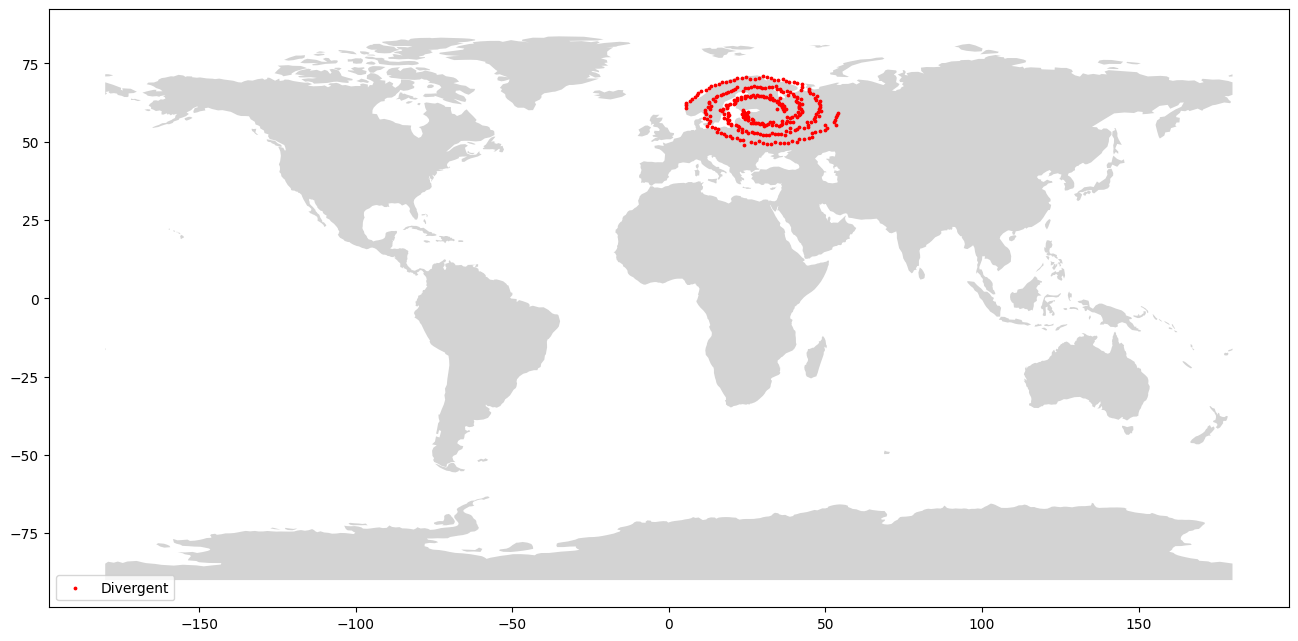

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
world.plot(ax=ax, color="lightgrey")

spiral_gdf.plot(ax=ax, marker="o", markersize=3, color="red", label="Divergent") # clock

plt.legend(loc="lower left")
plt.show()

In [16]:
# Section yet to be written...